# BASE: Calculate Regional Timeseries for Region Group

**ABOUT:**
Timelines of temperature anomalies, their variance, and their likelihood within the masking region of different polygon groups. 

This Notebook mirrors the functionality of `Update_02_Regional_Timelines.ipynb`, the purpose is to run any collection of timeseries that have been added into oisstools. Rather than dedicating another notebook for each new group of shapefile, we can implement new groups by adding their paths/information to `oisstools.py` then selecting the new collection here.

This notebook can also be used to quickly re-run any of the existing collections in the event of an error.

## Product 4. OISST Regional Timeseries

**Objective: Calculate full sea surface temperature histories for any group of polygons**

Use this notebook to process regional timelines for any group of polygons added to the `oisstools.py` module. This notebook is intended to phase out the notebooks for specific region groups.

In [1]:
# Load Packages
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os
import geopandas as gpd
import regionmask
import math
import oisstools as ot

# Set the workspace - local/ docker
box_root = ot.set_workspace("local")

# variable name to mask and make timeline from
var_name = "sst"

## Set Time Period and Reference Climatology to Use

In [2]:
# Years to Include
start_yr = 1981
end_yr = 2000

# Climate Reference Period
clim_ref_period = "1982-2011"

# print record of what you last ran
print(f"Process Time Period of {start_yr}-{end_yr} using {clim_ref_period} climatology.")

Process Time Period of 1981-2000 using 1982-2011 climatology.


## Select Group of Regions to Process

These region groups have been added to the oisstools.py module to ensure consistent naming conventions and path retrievals.

In [3]:
# Choose a set of regions to update (gmri_sst_focal_areas, lme, nmfs_trawl_regions)

# Option 1.
# update_regions = "gmri_sst_focal_areas"

# Option 2.
# update_regions = "lme"

# Option 3.
# update_regions = "nmfs_trawl_regions"

# Option 4.
# update_regions = "nelme_regions"

# Option 5.
update_regions = "gom_physio_regions"

print(f"Process Timeseries for: {update_regions}")

Process Timeseries for: gom_physio_regions


In [4]:
# Get their names from lookup catalog
region_names = ot.get_region_names(region_group = update_regions)
#print(f"Processing Timeseries for: {update_regions}")
for region in region_names:
    print(f" - {region}")

 - bay_of_fundy
 - bear_seamount
 - browns_bank
 - central_gulf_of_maine
 - continental_slope
 - eastern_coastal_shelf
 - georges_bank
 - georges_basin
 - jordan_basin
 - kelvin_seamount
 - manning_seamount
 - northern_coastal_shelf
 - scotian_coastal_shelf
 - scotian_shelf
 - southern_coastal_shelf
 - wikinson_basin


## Load Polygons for Each Region

browns_bank


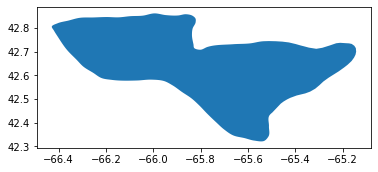

In [5]:
# Get paths to each shapefile
mask_paths = ot.get_timeseries_paths(box_root = box_root, 
                                     region_list = region_names, 
                                     region_group = update_regions, 
                                     polygons = True)

# Use paths to make list of loaded polygons
mask_list = []
for mask_path_i in mask_paths:
    mask_shape = gpd.read_file(mask_path_i)
    mask_list.append(mask_shape)
    #print(f"Loading Mask Area :  {mask_path_i}")

print(region_names[2])    
mask_list[2].plot()

## Step 2: Load OISST Collection

Timelines for these area haven't been calculates yet so it should be possible to do the full thing all at once. Steps are to load the observed data, get what the mean sst is for every day as a timeseries, as well as what the climatology is for that day of the year.

In [6]:
# Load OISSt using ot.load_box_oisst()
oisst_grid = ot.load_box_oisst(box_root, 
                               start_yr, 
                               end_yr, 
                               anomalies = False, 
                               do_parallel = True)
# oisst_grid.sst.isel(time = 0).plot()

# Add MOD
oisst_grid = ot.add_mod(oisst_grid, time_dim = "time")

## Step 3: Load OISST Climatology

From the global extent climatology we will want to get regional means for the areas of interest.

In [7]:
# Load the OISST Climatology
oisst_clim = ot.load_oisst_climatology(box_root, reference_period = clim_ref_period)

## Step 4: Create Masked Timeseries

So the steps to create a masked timeseries are straightforward. Once everything is prepped you simply create a mask with the geometry of the polygon of interest. You then extract the cells that fall within it, and calculatet the mean temperature and standard deviation for the area for each time step. These steps are repeated for the raw observations as well as the climate means in order to get anomalies from the 82-2011 climatology.

In [8]:
# NEW CODE - Masked Timeseries

# list to store the update period timeseries
clim_ts = [] # climatology timeseries
obs_ts = []  # temperature observations
new_ts = []  # anomaly timeseries


# Iterate through names and shapes simultaneously
for mask_shp, mask_name in zip(mask_list, region_names):
    
    
    
    #### 1. Get masked timeseries of climatology
    masked_clim = ot.calc_ts_mask(grid_obj = oisst_clim, 
                                  shp_obj  = mask_shp, 
                                  shp_name = mask_name,
                                  var_name = "sst",
                                  climatology = True)
    
    # Add to list
    clim_ts.append(masked_clim)
    
    
    
    #### 2. Get masked Timeseries of observations
    masked_sst = ot.calc_ts_mask(grid_obj = oisst_grid, 
                                 shp_obj  = mask_shp, 
                                 shp_name = mask_name,
                                 var_name = "sst",
                                 climatology = False)
    
    # Add MOD to observation temp ts
    masked_sst = ot.add_mod_to_ts(masked_sst)
    
    # Add to list
    obs_ts.append(masked_sst)
    

    
    
    #### 3. Merge on MOD
    
    # Merge on MOD
    anom_timeline = masked_sst.merge(masked_clim, how = "left", on = "modified_ordinal_day")

    #Set index as the date, drop time
    anom_timeline.index = anom_timeline.index = anom_timeline["time"]
    anom_timeline       = anom_timeline.drop(["time"], axis = 1)

    
    
    #### 4. Calc anoms
    
    # standard anomalies
    anom_timeline = anom_timeline.assign(anom = anom_timeline[f"{var_name}"] - anom_timeline[f"{var_name}_clim"])
    anom_timeline = anom_timeline.rename(columns = { "anom" : f"{var_name}_anom"})
    
    # area weighted anomalies
    anom_timeline = anom_timeline.assign(area_wtd_anom = anom_timeline[f"area_wtd_{var_name}"] - anom_timeline["area_wtd_clim"])
   
    # Reset Index
    anom_timeline = anom_timeline.reset_index()

    # re-order columns for peace of mind
    anom_timeline = anom_timeline[["time", "modified_ordinal_day", f"{var_name}", f"area_wtd_{var_name}", f"{var_name}_clim", "area_wtd_clim", f"{var_name}_anom", "area_wtd_anom", "clim_sd"]]
    anom_timeline.head()
    
    # Add to list
    new_ts.append(anom_timeline)
    
    print(f"{mask_name} timeseries processed.")



bay_of_fundy timeseries processed.
bear_seamount timeseries processed.
browns_bank timeseries processed.
central_gulf_of_maine timeseries processed.
continental_slope timeseries processed.
eastern_coastal_shelf timeseries processed.
georges_bank timeseries processed.
georges_basin timeseries processed.
jordan_basin timeseries processed.
kelvin_seamount timeseries processed.
manning_seamount timeseries processed.
northern_coastal_shelf timeseries processed.
scotian_coastal_shelf timeseries processed.
scotian_shelf timeseries processed.
southern_coastal_shelf timeseries processed.
wikinson_basin timeseries processed.


## QA/QC Visual Inspection

In [9]:
# Inspect a table
new_ts[0].head()

,time,modified_ordinal_day,sst,area_wtd_sst,sst_clim,area_wtd_clim,sst_anom,area_wtd_anom,clim_sd
0,1981-09-01,245,11.072778,11.073457,12.969889,12.968249,-1.897111,-1.894793,0.410132
1,1981-09-02,246,11.244444,11.246525,12.943203,12.941373,-1.698759,-1.694848,0.457851
2,1981-09-03,247,11.748333,11.750710,12.969833,12.967990,-1.221500,-1.217280,0.458614
3,1981-09-04,248,12.174999,12.175961,12.967019,12.965248,-0.792020,-0.789287,0.434870
4,1981-09-05,249,12.199444,12.199735,12.925018,12.923360,-0.725574,-0.723625,0.411604


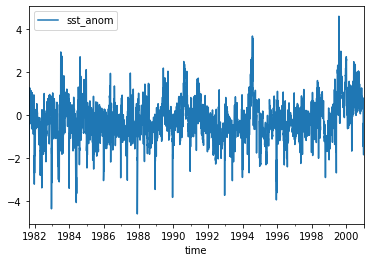

In [10]:
# Inspect via plot
new_ts[0].plot("time", "sst_anom")

## Step 5: Export

**NOTE:**
Some of the large marine ecosystem names contain a hyphen, so added an extra step to replace those.

In [11]:
# NEW Code - should be good to test

# Paths to where the timelines go
mask_ts_paths = ot.get_timeseries_paths(box_root = box_root, 
                                        region_list = region_names, 
                                        region_group = update_regions, 
                                        polygons = False)

# Use the file paths we looked up before to set the save destinations
for updated_timeline_i, update_path_i in zip(new_ts, mask_ts_paths):
    # save them
    print(f"Saving: {update_path_i}")
    updated_timeline_i.to_csv(update_path_i, index = False)

Saving: /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/regional_timeseries/GulfOfMainePhysioRegions/OISSTv2_anom_bay_of_fundy.csv
Saving: /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/regional_timeseries/GulfOfMainePhysioRegions/OISSTv2_anom_bear_seamount.csv
Saving: /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/regional_timeseries/GulfOfMainePhysioRegions/OISSTv2_anom_browns_bank.csv
Saving: /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/regional_timeseries/GulfOfMainePhysioRegions/OISSTv2_anom_central_gulf_of_maine.csv
Saving: /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/regional_timeseries/GulfOfMainePhysioRegions/OISSTv2_anom_continental_slope.csv
Saving: /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/regional_timeseries/GulfOfMainePhysioRegions/OISSTv2_anom_eastern_coastal_shelf.csv
Saving: /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/regional_timeseries/GulfOfMainePhysioRegions/OISSTv2_anom_georges_bank.csv
Saving: /Users/ake